In [896]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats

import feature_engine.imputation as mdi

from sklearn.model_selection import train_test_split
from sklearn.linear_model import BayesianRidge
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Table of contents
1. [Read Data](#read_data)
2. [Nulls](#nulls)
    1. [Frequencies](#frequencies)
    2. [Multiple Imputation by Chained Equations](#mice)
    3. [Imputation pipeline](#imputation_pipe)
3. [Encoding](#encoding)
    1. [Ordinal encoding](#oe)
    2. [Replace categories with frequency of observation](#fo)
    3. [Encoding with integers in a ordered manner](#encode_ordered)
    4. [Encoding with mean of target](#encode_mean)
    5. [Encoding with Weight of Evidence](#encode_woe)
4. [Numerical transformation (distribution)](#num_transformation)
    1. [Transforming variables with the logarithm](#log)
    2. [Transforming variables with the reciprocal function](#rec)
    3. [Transform with square and cube root](#sqrt_cbrt)
    4. [Using power tranformations](#power_transformation)
    5. [Box-Cox transformation](#box-cox)
5. [Variable discretization](#discretization)
    1. [Equal-width discretization](#ew_disc)
    2. [Equal frequency discretization](#ef_disc)
    3. [Discretization followed by categorical encoding](#disc_encoding)
    4. [K-means clustering discretization](#clust_disc)
    5. [Decision tree clustering discretization](#tree_disc)
6. [Outliers](#outliers)
    1. [Identification](#out_identification)
    2. [Winsorization](#winsorization)
    3. [Capping](#capping)
7. [Feature Scaling](#scaling)
    1. [Standard Scaler](#standard_scaler)
    2. [Mean normalization](#mean_scaler)
    3. [Min-max scaling](#min_max_scaler)
    4. [Absolute scaling](#absolute_scaler)
8. [Mathematical computations](#math)
    1. [Statistical operations](#statistical)
    2. [Polynomial expansion](#polynomial)
    3. [Deriving new features with decision trees](#new_feat_tree)
    4. [Principal Component Analysis](#pca)

## <a id="read_data"></a> Read Data

In [897]:
path = (Path('..') / 'Kaggle-Titanic-Spacechip-Competion')

In [898]:
train_data = pd.read_csv(path / 'train.csv')
test_data = pd.read_csv(path / 'test.csv')

In [899]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [900]:
data_num = train_data.select_dtypes(include=['int', 'float']).sample(25, random_state=4)
data_cat = train_data.select_dtypes(include=['object']).sample(25, random_state=4)
data_cat = data_cat.fillna(method='ffill')

y = train_data.iloc[data_num.index].Transported

C:\Users\Fábio\AppData\Local\Temp\ipykernel_12180\193768796.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_cat = data_cat.fillna(method='ffill')
C:\Users\Fábio\AppData\Local\Temp\ipykernel_12180\193768796.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_cat = data_cat.fillna(method='ffill')


In [901]:
train_data.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [902]:
def diagnostic_plots(df, variable):
    plt.figure(figsize=(10,2))
    plt.subplot(1, 2, 1)
    df[variable].hist(bins=30)
    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.show()

## Nulls <a id="nulls"></a>

In [903]:
train_data.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [904]:
print(train_data.select_dtypes(include='object').nunique())
print(f'\nlen: {len(train_data)}')

PassengerId    8693
HomePlanet        3
CryoSleep         2
Cabin          6560
Destination       3
VIP               2
Name           8473
dtype: int64

len: 8693


### Frequencies <a id="frequencies"></a>

In [905]:
for col in train_data.select_dtypes(include='object').columns.difference(['PassengerId', 'Cabin', 'Name']):
    print(train_data[col].value_counts()/len(train_data), '\n')

CryoSleep
False    0.625676
True     0.349362
Name: count, dtype: float64 

Destination
TRAPPIST-1e      0.680433
55 Cancri e      0.207063
PSO J318.5-22    0.091568
Name: count, dtype: float64 

HomePlanet
Earth     0.529391
Europa    0.245140
Mars      0.202347
Name: count, dtype: float64 

VIP
False    0.953756
True     0.022892
Name: count, dtype: float64 



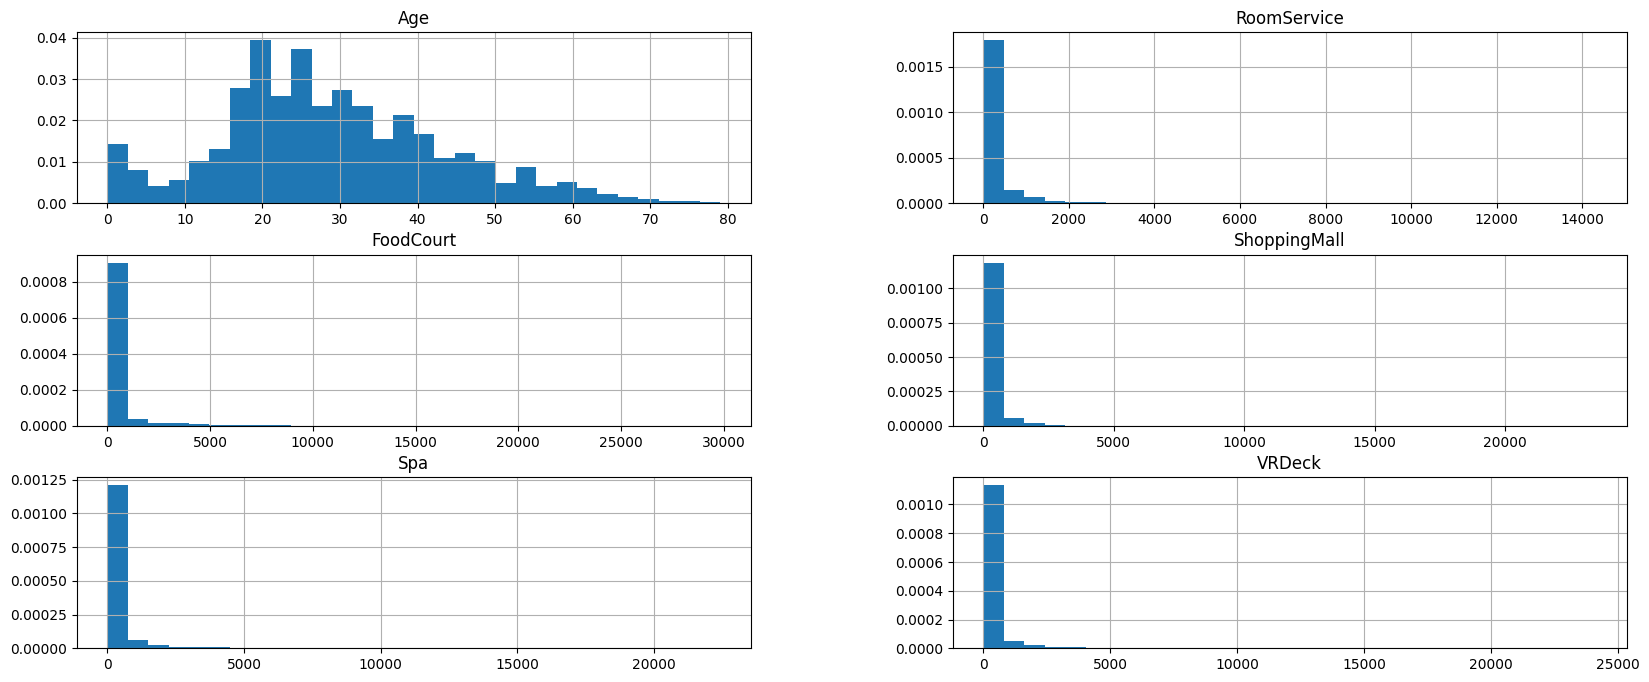

In [906]:
train_data.hist(bins=30, figsize=(20,8), density=True)
plt.show()

<Axes: ylabel='Spa'>

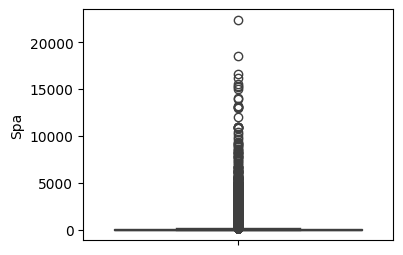

In [907]:
plt.figure(figsize=(4,3))
sns.boxplot(y=train_data['Spa'])

### Multiple Imputation by Chained Equations <a id="mice"></a>

In [ ]:
# Imports
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor

In [909]:
imputer_bay = IterativeImputer(estimator=BayesianRidge(), max_iter=10)
data_bay = imputer_bay.fit_transform(data_num)
pd.DataFrame(data_bay, columns=imputer_bay.get_feature_names_out())

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,27.0,182.0,0.0,0.0,0.0,376.0
1,18.0,0.0,0.0,0.0,0.0,0.0
2,20.0,362.0,0.0,31.0,12.0,483.0
3,15.0,0.0,225.0,0.0,998.0,0.0
4,38.0,1517.0,0.0,0.0,27.0,0.0
5,31.0,0.0,0.0,0.0,0.0,0.0
6,53.0,0.0,864.0,49.0,39.0,2376.0
7,43.0,0.0,9.0,1145.0,0.0,0.0
8,15.0,852.0,0.0,0.0,135.0,0.0
9,14.0,7.0,781.0,0.0,0.0,0.0


In [910]:
imputer_kn = IterativeImputer(estimator=KNeighborsRegressor(), max_iter=10)
data_kn = imputer_kn.fit_transform(data_num)
df_kn = pd.DataFrame(data_kn, columns=imputer_kn.get_feature_names_out())
df_kn.VRDeck.mean()

np.float64(191.08)

In [1048]:
imputer_bayes = IterativeImputer(
    estimator=BayesianRidge(),
    max_iter=10,
    random_state=0)

imputer_knn = IterativeImputer(
    estimator=KNeighborsRegressor(n_neighbors=5),
    max_iter=10,
    random_state=0)

imputer_nonLin = IterativeImputer(
    estimator=DecisionTreeRegressor(
        max_features='sqrt', random_state=0),
    max_iter=10,
    random_state=0)

imputer_missForest = IterativeImputer(
    estimator=ExtraTreesRegressor(
        n_estimators=10, random_state=0),
    max_iter=10,
    random_state=0)

In [1057]:
X_train_bayes = imputer_bayes.fit_transform(data_num)
X_train_knn = imputer_knn.fit_transform(data_num)
X_train_nonLin = imputer_nonLin.fit_transform(data_num)
X_train_missForest = imputer_missForest.fit_transform(data_num)

X_train_bayes = pd.DataFrame(X_train_bayes, columns=imputer_bayes.get_feature_names_out())
X_train_knn = pd.DataFrame(X_train_knn, columns=imputer_knn.get_feature_names_out())
X_train_nonLin = pd.DataFrame(X_train_nonLin, columns=imputer_nonLin.get_feature_names_out())
X_train_missForest = pd.DataFrame(X_train_missForest, columns=imputer_missForest.get_feature_names_out())

<Axes: ylabel='Density'>

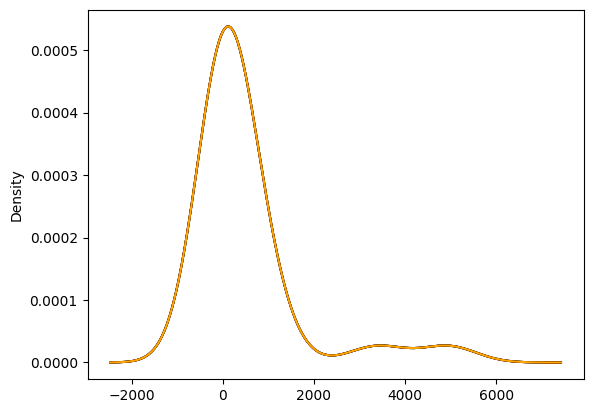

In [1059]:
fig = plt.figure()
ax = fig.add_subplot(111)


data_num['FoodCourt'].plot(kind='kde', ax=ax, color='blue')
X_train_bayes['FoodCourt'].plot(kind='kde', ax=ax, color='green')
X_train_knn['FoodCourt'].plot(kind='kde', ax=ax, color='red')
X_train_nonLin['FoodCourt'].plot(kind='kde', ax=ax, color='black')
X_train_missForest['FoodCourt'].plot(kind='kde', ax=ax, color='orange')

### Imputation pipeline <a id="imputation_pipe"></a>

In [911]:
features_num_arbitrary = ['VRDeck','ShoppingMall']
features_num_kn = ['Age', 'RoomService']
features_num_median = ['Spa','FoodCourt']

#### sklearn

In [912]:
# Imports
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

In [913]:
imputer_num_arbitrary = Pipeline(steps=[
                                 ('imputer', SimpleImputer(strategy='constant', fill_value=327)),
])
imputer_num_kn = Pipeline(steps=[
                                 ('imputer', IterativeImputer(estimator=KNeighborsRegressor(), max_iter=10)),
])
imputer_num_median = Pipeline(steps=[
                                 ('imputer', SimpleImputer(strategy='median')),
])

In [914]:
preprocessor = ColumnTransformer(transformers=[
    ('imp_num_arbitraty', imputer_num_arbitrary, features_num_arbitrary),
    ('imp_num_kn', imputer_num_kn, features_num_kn),
    ('imp_num_median', imputer_num_median, features_num_median),
], remainder='passthrough')

In [915]:
pd.DataFrame(preprocessor.fit_transform(data_num), columns=preprocessor.get_feature_names_out())

,imp_num_arbitraty__VRDeck,imp_num_arbitraty__ShoppingMall,imp_num_kn__Age,imp_num_kn__RoomService,imp_num_median__Spa,imp_num_median__FoodCourt
0,376.0,0.0,27.0,182.0,0.0,0.0
1,0.0,0.0,18.0,0.0,0.0,0.0
2,483.0,31.0,20.0,362.0,12.0,0.0
3,0.0,0.0,15.0,0.0,998.0,225.0
4,0.0,0.0,38.0,1517.0,27.0,0.0
5,0.0,0.0,31.0,0.0,0.0,0.0
6,2376.0,49.0,53.0,0.0,39.0,864.0
7,0.0,1145.0,43.0,0.0,0.0,9.0
8,0.0,0.0,15.0,852.0,135.0,0.0
9,0.0,0.0,14.0,7.0,0.0,781.0


#### feature_engine

In [916]:
# Imports
import feature_engine.imputation as mdi

In [917]:
# Feature-engine imputers
imp_num_arbitrary = mdi.ArbitraryNumberImputer(arbitrary_number=-999)
imp_num_kn = mdi.MeanMedianImputer(imputation_method='mean')

# Scikit-learn imputer
imp_num_median = SimpleImputer(strategy='median')

In [918]:
preprocessor = ColumnTransformer(
    transformers=[
        ('imp_num_arbitrary', imp_num_arbitrary, features_num_arbitrary),
        ('imp_num_kn', imp_num_kn, features_num_kn),
        ('imp_num_median', imp_num_median, features_num_median)
    ],
    remainder='passthrough'  # Keeps the rest of the columns unchanged
)

pipe = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

In [919]:
pd.DataFrame(pipe.fit_transform(data_num), columns=pipe.get_feature_names_out())

,imp_num_arbitrary__VRDeck,imp_num_arbitrary__ShoppingMall,imp_num_kn__Age,imp_num_kn__RoomService,imp_num_median__Spa,imp_num_median__FoodCourt
0,376.0,0.0,27.0,182.0,0.0,0.0
1,0.0,0.0,18.0,0.0,0.0,0.0
2,483.0,31.0,20.0,362.0,12.0,0.0
3,0.0,0.0,15.0,0.0,998.0,225.0
4,0.0,0.0,38.0,1517.0,27.0,0.0
5,0.0,0.0,31.0,0.0,0.0,0.0
6,2376.0,49.0,53.0,0.0,39.0,864.0
7,0.0,1145.0,43.0,0.0,0.0,9.0
8,0.0,0.0,15.0,852.0,135.0,0.0
9,0.0,0.0,14.0,7.0,0.0,781.0


### Categorical Imputation

In [1043]:
# Imports
from feature_engine.imputation import CategoricalImputer

In [ ]:
imputer = CategoricalImputer(
    fill_value="missing"
)

In [1047]:
imputer = CategoricalImputer(
    imputation_method="frequent"
)

## Encoding <a id="encoding"></a>

### Ordinal encoding <a id="oe"></a>

In [920]:
# Imports
from sklearn.preprocessing import OrdinalEncoder as sk_oe
from feature_engine.encoding import OrdinalEncoder as fe_oe

In [921]:
vars_to_oe = ['HomePlanet','Destination']

oe = sk_oe()

encoded = pd.DataFrame(oe.fit_transform(data_cat[vars_to_oe]), columns=oe.get_feature_names_out())
encoded.index = data_cat.index

pd.concat([data_cat, encoded], axis=1)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,VIP,Name,HomePlanet,Destination
991,1053_01,Earth,False,F/199/S,PSO J318.5-22,False,Rald Colleruces,0.0,1.0
4508,4792_01,Earth,True,G/782/S,TRAPPIST-1e,False,Stace Drakeekss,0.0,2.0
4577,4879_01,Earth,False,G/786/P,TRAPPIST-1e,False,Emilla Hebernandry,0.0,2.0
29,0025_01,Earth,False,F/6/S,TRAPPIST-1e,False,Karard Brookenson,0.0,2.0
194,0217_01,Earth,False,F/47/P,TRAPPIST-1e,False,Prilly Shieldson,0.0,2.0
3348,3605_01,Earth,True,G/592/P,55 Cancri e,False,Joyces Alldson,0.0,0.0
4232,4505_01,Europa,False,C/165/S,55 Cancri e,False,Erraid Wirdley,1.0,0.0
2329,2509_01,Earth,False,F/483/S,TRAPPIST-1e,False,Wen Georgasey,0.0,2.0
1627,1723_01,Earth,False,E/128/S,TRAPPIST-1e,False,Ivaney Holcompson,0.0,2.0
698,0729_01,Earth,False,E/53/S,TRAPPIST-1e,False,Briam Lewinton,0.0,2.0


### Replace categories with frequency of observation <a id="fo"></a>

In [922]:
# Imports
from feature_engine.encoding import CountFrequencyEncoder

In [923]:
count_map = data_cat['Destination'].value_counts().to_dict()
print(count_map)

{'TRAPPIST-1e': 20, '55 Cancri e': 4, 'PSO J318.5-22': 1}


In [924]:
count_enc = CountFrequencyEncoder(encoding_method='count', variables=vars_to_oe, missing_values='ignore') # or encoding_method='frequency'

In [925]:
data_frequency = count_enc.fit_transform(data_cat)

### Encoding with integers in a ordered manner <a id="encode_ordered"></a>
Good for linear models

In [926]:
# Imports
from feature_engine.encoding import OrdinalEncoder

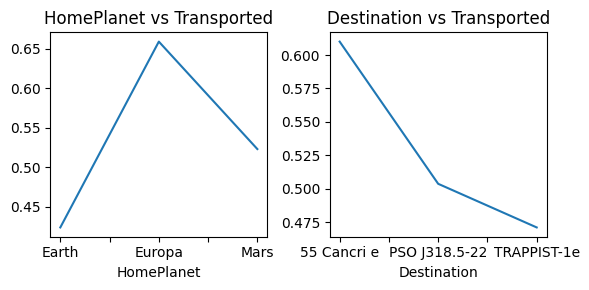

In [927]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3))

train_data.groupby(['HomePlanet'])['Transported'].mean().plot(ax=axes[0], title='HomePlanet vs Transported')
train_data.groupby(['Destination'])['Transported'].mean().plot(ax=axes[1], title='Destination vs Transported')

plt.tight_layout()
plt.show()

In [928]:
ordinal_enc = OrdinalEncoder(encoding_method='ordered', variables=['HomePlanet','Destination'], missing_values='ignore')
data_ordinal = ordinal_enc.fit_transform(data_cat, y)

### Encoding with mean of target <a id="encode_mean"></a>

In [929]:
# Imports
from feature_engine.encoding import MeanEncoder

In [930]:
data_cat.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25 entries, 991 to 4641
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   PassengerId  25 non-null     object
 1   HomePlanet   25 non-null     object
 2   CryoSleep    25 non-null     bool  
 3   Cabin        25 non-null     object
 4   Destination  25 non-null     object
 5   VIP          25 non-null     bool  
 6   Name         25 non-null     object
dtypes: bool(2), object(5)
memory usage: 1.2+ KB


In [931]:
variables=['HomePlanet','Destination']

mean_enc = MeanEncoder(variables=variables)
a = mean_enc.fit_transform(data_cat, y)

In [932]:
data_mean = mean_enc.fit_transform(data_cat, y)
data_mean

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,VIP,Name
991,1053_01,0.375000,False,F/199/S,0.00,False,Rald Colleruces
4508,4792_01,0.375000,True,G/782/S,0.45,False,Stace Drakeekss
4577,4879_01,0.375000,False,G/786/P,0.45,False,Emilla Hebernandry
29,0025_01,0.375000,False,F/6/S,0.45,False,Karard Brookenson
194,0217_01,0.375000,False,F/47/P,0.45,False,Prilly Shieldson
3348,3605_01,0.375000,True,G/592/P,1.00,False,Joyces Alldson
4232,4505_01,0.714286,False,C/165/S,1.00,False,Erraid Wirdley
2329,2509_01,0.375000,False,F/483/S,0.45,False,Wen Georgasey
1627,1723_01,0.375000,False,E/128/S,0.45,False,Ivaney Holcompson
698,0729_01,0.375000,False,E/53/S,0.45,False,Briam Lewinton


### Encoding with Weight of Evidence <a id="encode_woe"></a>

In [933]:
# Imports
from feature_engine.encoding import WoEEncoder

In [934]:
woe_enc = WoEEncoder(variables=['HomePlanet','Destination'])

In [935]:
# data_woe = woe_enc.fit_transform(data_cat, y)
# data_woe

## Numerical transformation (distribution) <a id="num_transformation"></a>

### Transforming variables with the logarithm <a id="log"></a>

In [936]:
# Imports
from sklearn.preprocessing import FunctionTransformer
from feature_engine.transformation import LogTransformer

In [937]:
data_tf = data_num.copy()

data_tf = np.log(data_num+1e-9)

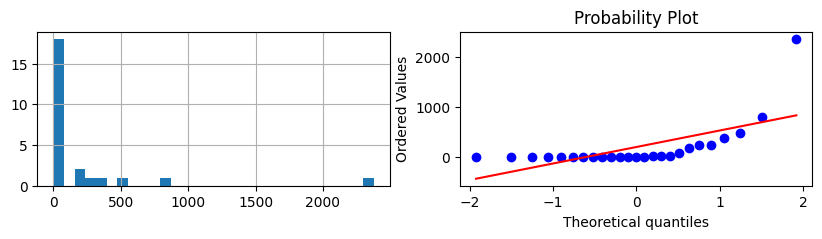

In [938]:
diagnostic_plots(data_num, 'VRDeck')

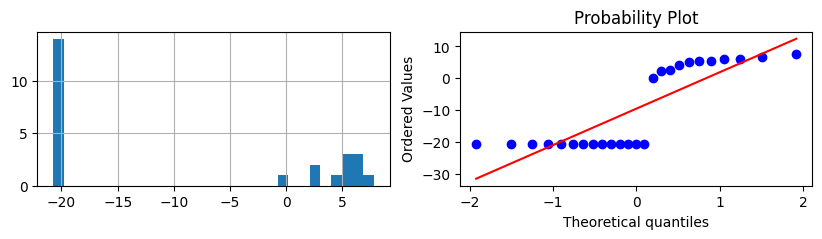

In [939]:
diagnostic_plots(data_tf, 'VRDeck')

In [940]:
# "Scales" the data as well

In [941]:
transformer = FunctionTransformer(lambda x: np.log(x + 1e-9))

data_tf = transformer.transform(data_num)

pd.DataFrame(data_tf)

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
991,3.295837,5.204007,-20.723266,-20.723266,-2.072327e+01,5.929589e+00
4508,2.890372,-20.723266,-20.723266,-20.723266,-2.072327e+01,-2.072327e+01
4577,2.995732,5.891644,-20.723266,3.433987,2.484907e+00,6.180017e+00
29,2.708050,-20.723266,5.416100,-20.723266,6.905753e+00,-2.072327e+01
194,3.637586,7.324490,-20.723266,-20.723266,3.295837e+00,-2.072327e+01
3348,3.433987,-20.723266,-20.723266,-20.723266,-2.072327e+01,-2.072327e+01
4232,3.970292,-20.723266,6.761573,3.891820,3.663562e+00,7.773174e+00
2329,3.761200,-20.723266,2.197225,7.043160,-2.072327e+01,-2.072327e+01
1627,2.708050,6.747587,-20.723266,-20.723266,4.905275e+00,-2.072327e+01
698,2.639057,1.945910,6.660575,-20.723266,-2.072327e+01,-2.072327e+01


### Transforming variables with the reciprocal function (1/x) <a id="rec"></a>

In [942]:
# Imports
from feature_engine.transformation import ReciprocalTransformer

In [943]:
data_rec = np.reciprocal(data_num + 1e-1)

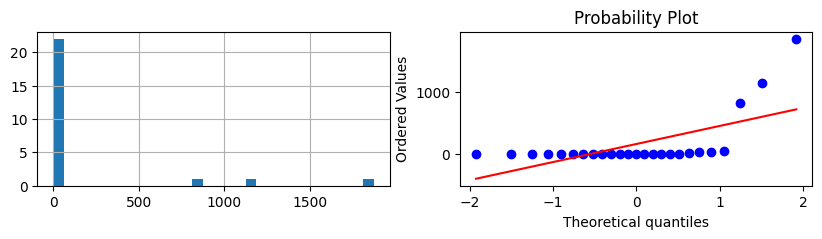

In [944]:
diagnostic_plots(data_num, 'ShoppingMall')

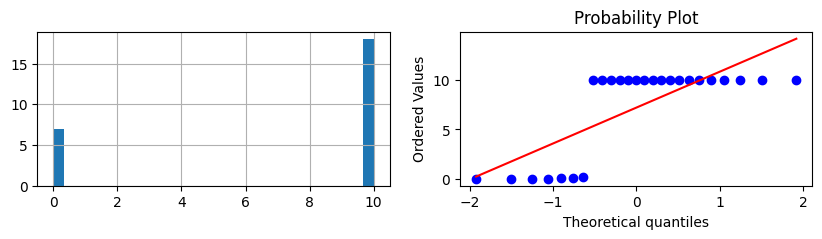

In [945]:
diagnostic_plots(data_rec, 'ShoppingMall')

In [946]:
transformer = FunctionTransformer(lambda x: np.reciprocal(x + 1e-1))
data_rec = transformer.transform(data_num)

In [947]:
# Does not work because of the 0s

# rt = ReciprocalTransformer()
# data_rec = rt.fit_transform(data)

### Transform with square and cube root <a id="sqrt_cbrt"></a>

In [948]:
data_tf = data_num.copy()

In [949]:
data_tf_sqrt = np.sqrt(data_num)
data_tf_cbrt = np.cbrt(data_num)

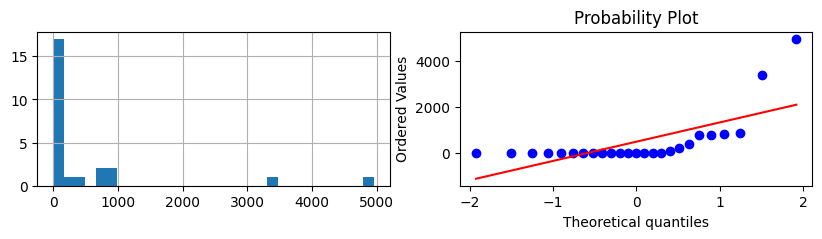

In [950]:
diagnostic_plots(data_num, 'FoodCourt')

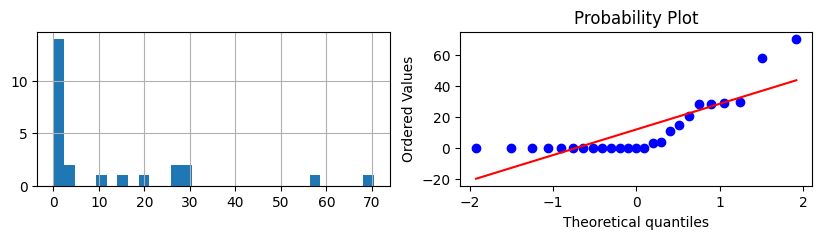

In [951]:
diagnostic_plots(data_tf_sqrt, 'FoodCourt')

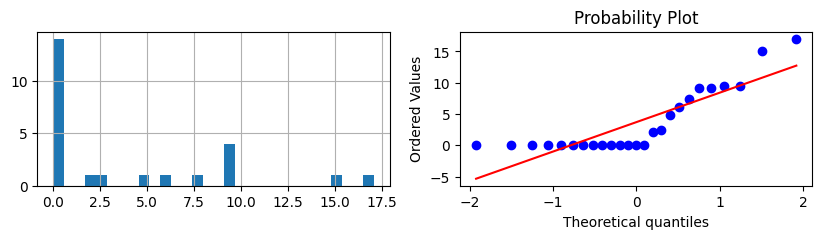

In [952]:
diagnostic_plots(data_tf_cbrt, 'FoodCourt')

### Using power tranformations <a id="power_transformation"></a>

In [953]:
# Imports
from feature_engine.transformation import PowerTransformer

In [954]:
data_pt = data_num.copy()

In [955]:
pt = PowerTransformer(exp=0.1)
df_pt = pt.fit_transform(data_pt)

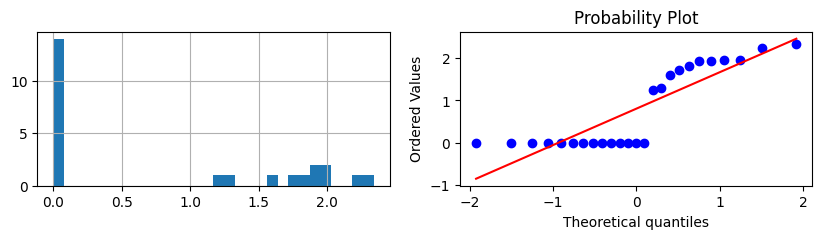

In [956]:
diagnostic_plots(df_pt, 'FoodCourt')

### Box-Cox transformation <a id="box-cox"></a>

In [957]:
# Imports
import scipy.stats as stats
from sklearn.preprocessing import PowerTransformer
from feature_engine.transformation import BoxCoxTransformer

In [958]:
data_bc = data_num.copy()

data_bc = data_bc+1e-5

In [959]:
# data_bc['FoodCourt'], param = stats.boxcox(data_bc['FoodCourt'])
# print('Optimal λ: ', param)

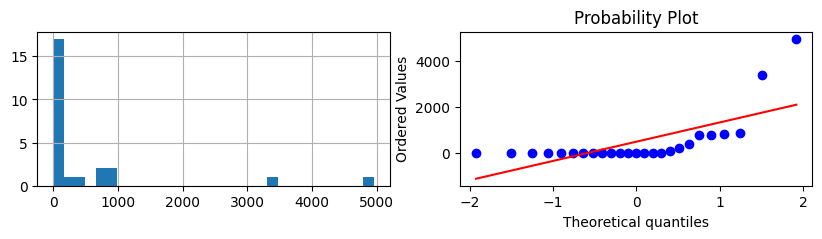

In [960]:
diagnostic_plots(data_num, 'FoodCourt')

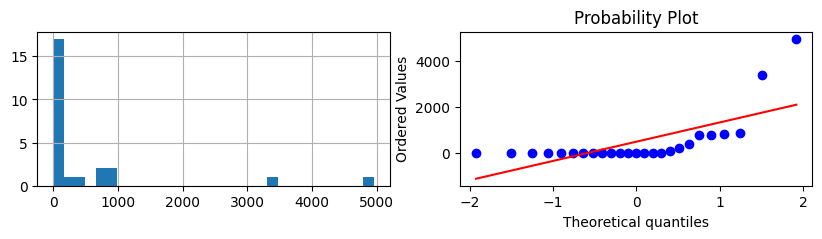

In [961]:
diagnostic_plots(data_bc, 'FoodCourt')

In [962]:
transformer = PowerTransformer(method='box-cox', standardize=True)

In [963]:
array_bc = transformer.fit_transform(data_bc)
df_bc = pd.DataFrame(array_bc, columns=transformer.get_feature_names_out())

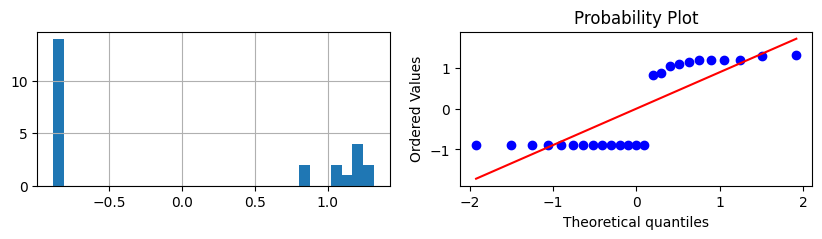

In [964]:
diagnostic_plots(df_bc, 'FoodCourt')

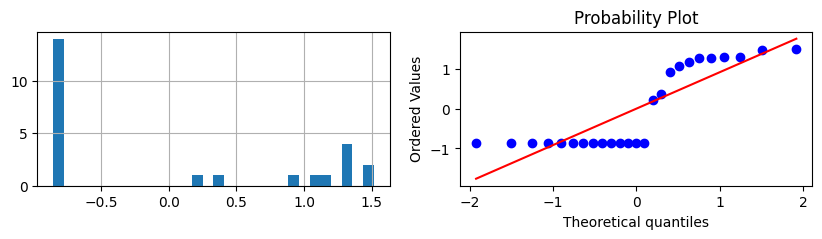

In [965]:
transformer = PowerTransformer(method='yeo-johnson', standardize=True)

array_yj = transformer.fit_transform(data_bc)
df_yj = pd.DataFrame(array_yj, columns=transformer.get_feature_names_out())

diagnostic_plots(df_yj, 'FoodCourt')

In [966]:
transformer.lambdas_

array([ 0.59633819, -0.52936877, -0.20696097, -0.60351551, -0.20867825,
       -0.28596011])

## Variable discretization <a id="discretization"></a>

In [967]:
data = train_data.select_dtypes(include=['int', 'float']).sample(25, random_state=25)

data = data.fillna(method='bfill')

data

C:\Users\Fábio\AppData\Local\Temp\ipykernel_12180\4153614027.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='bfill')


,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
314,36.0,520.0,0.0,1865.0,0.0,0.0
3842,28.0,0.0,0.0,0.0,0.0,0.0
5255,14.0,30.0,757.0,115.0,0.0,0.0
5900,37.0,0.0,0.0,0.0,0.0,0.0
3051,20.0,2598.0,927.0,0.0,866.0,2.0
7412,39.0,3030.0,79.0,0.0,0.0,0.0
5026,18.0,0.0,0.0,55.0,2288.0,1.0
1032,22.0,0.0,78.0,642.0,0.0,0.0
7700,49.0,0.0,4.0,50.0,0.0,746.0
3571,36.0,90.0,2050.0,0.0,15.0,1244.0


In [968]:
data_disc = data.copy()

### Equal-width discretization <a id="ew_disc"></a>

In [969]:
# Imports
from sklearn.preprocessing import KBinsDiscretizer
from feature_engine.discretisation import EqualWidthDiscretiser

In [970]:
ew_disc = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')

ew_disc = EqualWidthDiscretiser(bins=10)

ew_df = ew_disc.fit_transform(data_disc)

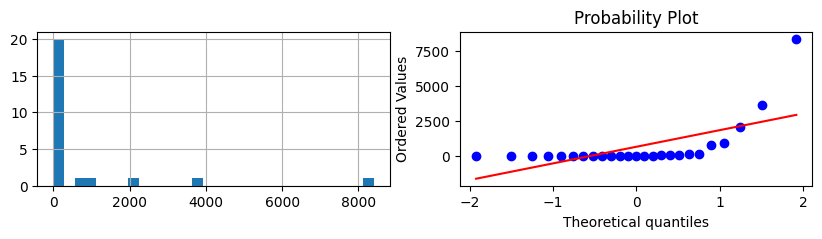

In [971]:
diagnostic_plots(data_disc, 'FoodCourt')

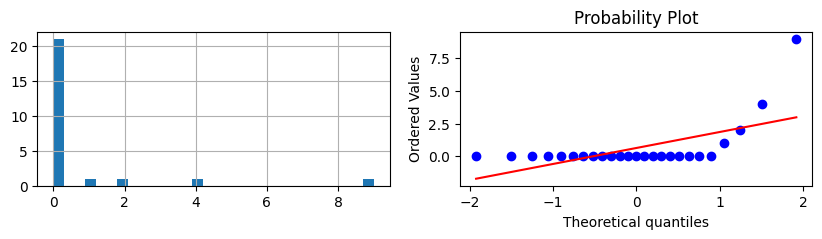

In [972]:
diagnostic_plots(ew_df, 'FoodCourt')

### Equal frequency discretization <a id="ef_disc"></a>

In [973]:
# Imports
from sklearn.preprocessing import KBinsDiscretizer
from feature_engine.discretisation import EqualFrequencyDiscretiser

In [974]:
ef_disc = EqualFrequencyDiscretiser(q=10)

In [975]:
ef_df = ef_disc.fit_transform(data_disc)

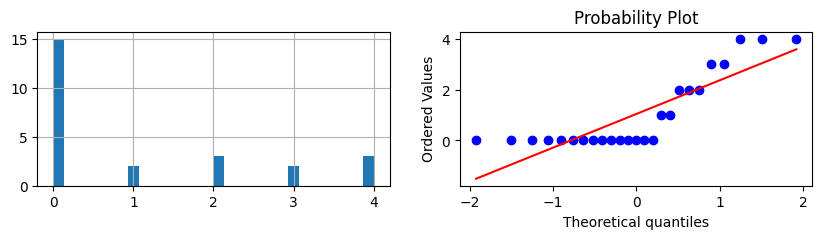

In [976]:
diagnostic_plots(ef_df, 'FoodCourt')

### Discretization followed by categorical encoding <a id="disc_encoding"></a>

Doing this will make it so that the mean o the target variable is ordered on all variables

Good for linear models

In [977]:
# Imports
from feature_engine.discretisation import EqualFrequencyDiscretiser
from feature_engine.encoding import OrdinalEncoder

In [978]:
ef_disc = EqualFrequencyDiscretiser(q=10, return_object=True)

In [979]:
ef_df = ef_disc.fit_transform(data_disc)

<Figure size 400x300 with 0 Axes>

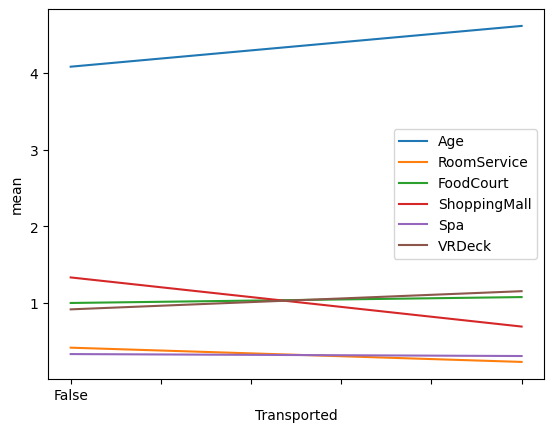

In [980]:
y.index = ef_df.index

plt.figure(figsize=(4,3))
pd.concat([ef_df, y],axis=1).groupby('Transported').mean().plot()
plt.ylabel('mean')
plt.show()

In [981]:
enc = OrdinalEncoder(encoding_method = 'ordered')
encoded = enc.fit_transform(ef_df, y)

<Figure size 200x300 with 0 Axes>

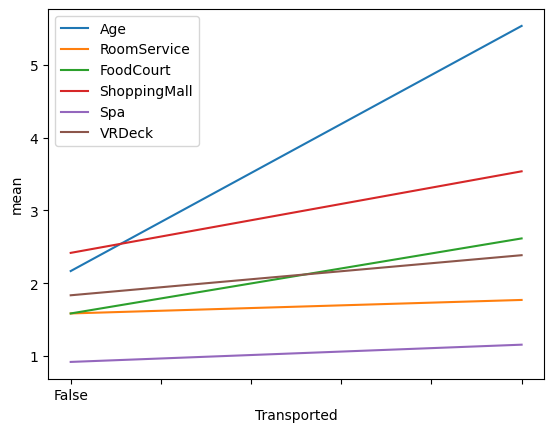

In [982]:
y.index = encoded.index

plt.figure(figsize=(2,3))
pd.concat([encoded, y],axis=1).groupby('Transported').mean().plot()
plt.ylabel('mean')
plt.show()

### K-means clustering discretization <a id="clust_disc"></a>

In [983]:
# Imports
from sklearn.preprocessing import KBinsDiscretizer

In [984]:
kb_disc = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='kmeans')
kb_df = kb_disc.fit_transform(data_disc)
kb_df = pd.DataFrame(kb_df, columns=kb_disc.get_feature_names_out())

In [985]:
kb_df

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,2.0,2.0,0.0,3.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,1.0,0.0,0.0
3,2.0,0.0,0.0,0.0,0.0,0.0
4,0.0,3.0,1.0,0.0,1.0,0.0
5,2.0,3.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,1.0,3.0,0.0
7,1.0,0.0,0.0,2.0,0.0,0.0
8,3.0,0.0,0.0,1.0,0.0,2.0
9,2.0,1.0,2.0,0.0,0.0,2.0


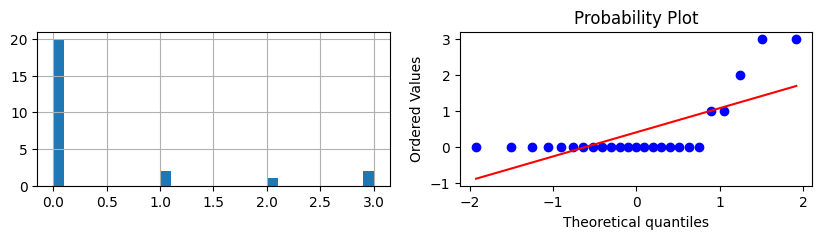

In [986]:
diagnostic_plots(kb_df, 'Spa')

### Decision tree clustering discretization <a id="tree_disc"></a>

In [987]:
# Imports
from feature_engine.discretisation import DecisionTreeDiscretiser

In [988]:
tree_disc = DecisionTreeDiscretiser(cv=10,
                                   scoring='accuracy',
                                   regression=False, param_grid={'max_depth': [1,2,3,4]})

In [989]:
dt_df = tree_disc.fit_transform(data_disc, y)
dt_df = pd.DataFrame(dt_df, columns=tree_disc.get_feature_names_out())

In [990]:
tree_disc.binner_dict_['ShoppingMall'].best_estimator_

DecisionTreeClassifier(max_depth=1)

In [991]:
dt_df

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
314,0.625000,0.000000,0.571429,0.300000,0.55,0.444444
3842,0.625000,0.545455,0.571429,0.666667,0.55,0.444444
5255,0.333333,0.545455,0.000000,0.300000,0.55,0.444444
5900,0.625000,0.545455,0.571429,0.666667,0.55,0.444444
3051,0.333333,0.000000,0.000000,0.666667,0.00,0.444444
7412,0.625000,1.000000,1.000000,0.666667,0.55,0.444444
5026,0.333333,0.545455,0.571429,0.300000,1.00,0.444444
1032,0.333333,0.545455,0.000000,0.300000,0.55,0.444444
7700,0.625000,0.545455,0.000000,0.300000,0.55,0.714286
3571,0.625000,0.545455,1.000000,0.666667,0.55,0.714286


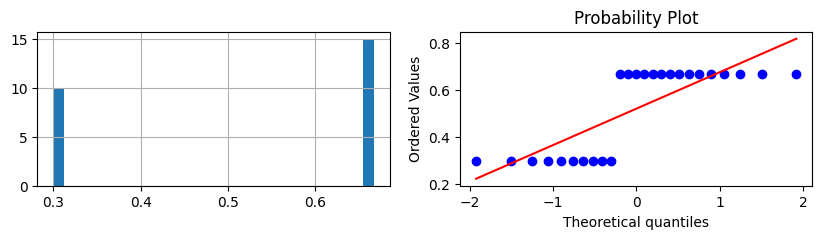

In [992]:
diagnostic_plots(dt_df, 'ShoppingMall')

<Figure size 400x300 with 0 Axes>

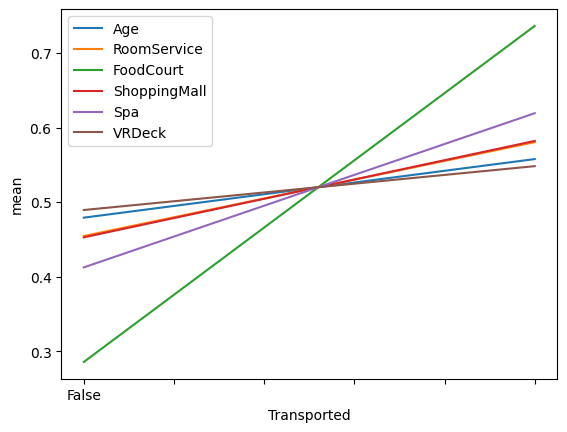

In [993]:
y.index = dt_df.index

plt.figure(figsize=(4,3))
pd.concat([dt_df, y],axis=1).groupby('Transported').mean().plot()
plt.ylabel('mean')
plt.show()

## Outliers <a id="outliers"></a>

### Identification <a id="out_identification"></a>

In [994]:
def find_boundaries(df, variable, distance):

    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)

    upper_bound = df[variable].quantile(0.75) + (IQR*distance)
    lower_bound = df[variable].quantile(0.25) - (IQR*distance)

    return upper_bound, lower_bound

upper_bound, lower_bound = find_boundaries(train_data, 'Spa', 3)
upper_bound, lower_bound

(np.float64(236.0), np.float64(-177.0))

In [995]:
outliers = np.where(train_data.Spa > upper_bound, True,
                    np.where(train_data.Spa < lower_bound, True, False))

In [996]:
train_data.loc[outliers, 'Spa']

1        549.0
2       6715.0
3       3329.0
4        565.0
5        291.0
         ...  
8645     660.0
8652    2868.0
8657    1107.0
8688    1643.0
8691     353.0
Name: Spa, Length: 1576, dtype: float64

In [997]:
train_data.select_dtypes(include=['int', 'float']).max() - train_data.select_dtypes(include=['int', 'float']).min()

Age                79.0
RoomService     14327.0
FoodCourt       29813.0
ShoppingMall    23492.0
Spa             22408.0
VRDeck          24133.0
dtype: float64

In [998]:
train_data.isnull().sum().sort_values(ascending=True)

PassengerId       0
Transported       0
Age             179
RoomService     181
Destination     182
FoodCourt       183
Spa             183
VRDeck          188
Cabin           199
Name            200
HomePlanet      201
VIP             203
ShoppingMall    208
CryoSleep       217
dtype: int64

### Winsorization <a id="winsorization"></a>

In [999]:
# Imports
from feature_engine.outliers import Winsorizer

In [1000]:
winsorizer = Winsorizer(tail='both', capping_method='quantiles', )
wins_df = winsorizer.fit_transform(data_num)

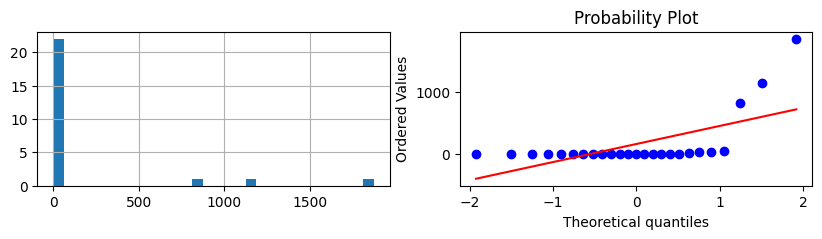

In [1001]:
diagnostic_plots(data_num, 'ShoppingMall')

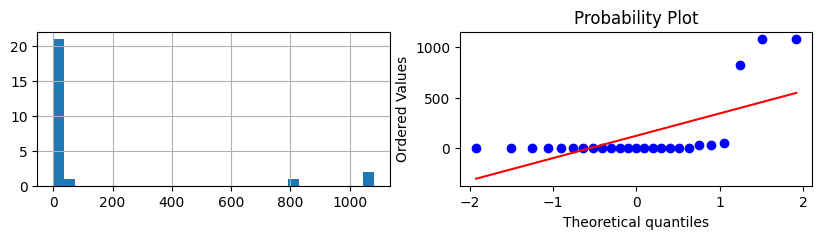

In [1002]:
diagnostic_plots(wins_df, 'ShoppingMall')

In [1003]:
winsorizer.left_tail_caps_

{'Age': 14.2,
 'RoomService': 0.0,
 'FoodCourt': 0.0,
 'ShoppingMall': 0.0,
 'Spa': 0.0,
 'VRDeck': 0.0}

In [1004]:
winsorizer.right_tail_caps_

{'Age': 56.19999999999999,
 'RoomService': 844.3999999999999,
 'FoodCourt': 2880.799999999993,
 'ShoppingMall': 1081.1999999999991,
 'Spa': 2210.599999999998,
 'VRDeck': 730.9999999999991}

### Capping <a id="capping"></a>

In [1005]:
winsorizer_2 = Winsorizer(tail='both', capping_method='gaussian', fold=3)
wins_df_2 = winsorizer_2.fit_transform(data_num)

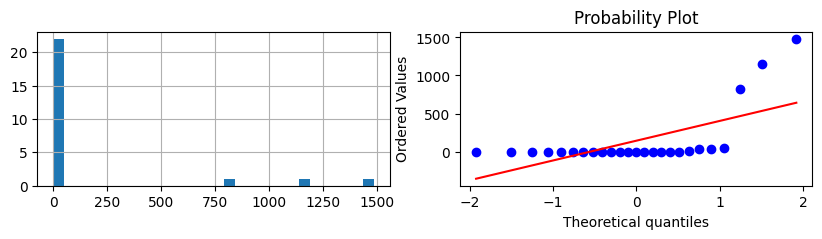

In [1006]:
diagnostic_plots(wins_df_2, 'ShoppingMall')

In [1007]:
winsorizer_2.left_tail_caps_

{'Age': -11.231399280382597,
 'RoomService': -932.5006788808638,
 'FoodCourt': -2937.7120655691856,
 'ShoppingMall': -1166.5655209570664,
 'Spa': -3050.613842709213,
 'VRDeck': -1264.5914541406657}

In [1008]:
winsorizer_2.right_tail_caps_

{'Age': 69.3113992803826,
 'RoomService': 1268.1806788808638,
 'FoodCourt': 3927.9520655691854,
 'ShoppingMall': 1483.1255209570663,
 'Spa': 4008.1338427092132,
 'VRDeck': 1646.7514541406656}

## Feature Scaling <a id="scaling"></a>

### Standard Scaler <a id="standard_scaler"></a>

In [1009]:
# Imports
from sklearn.preprocessing import StandardScaler

In [1010]:
scaler = StandardScaler()
scaler_df = scaler.fit_transform(data_num)
scaler_df = pd.DataFrame(scaler_df, columns=scaler.get_feature_names_out())

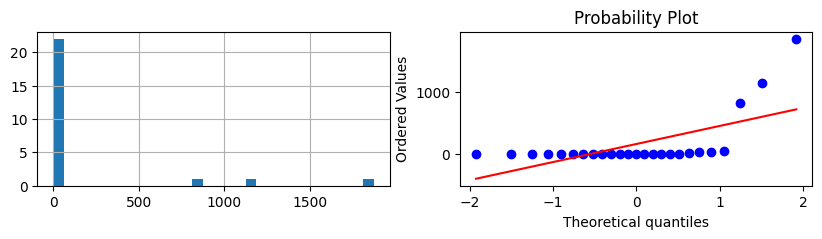

In [1011]:
diagnostic_plots(data_num, 'ShoppingMall')

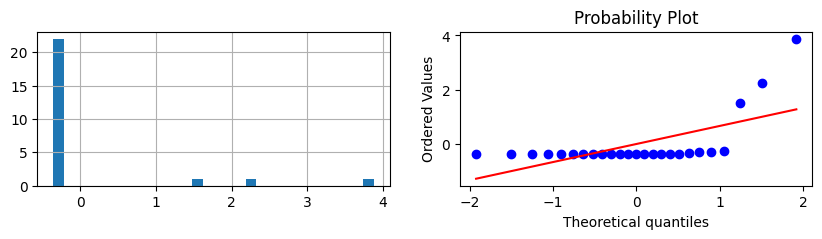

In [1012]:
diagnostic_plots(scaler_df, 'ShoppingMall')

### Mean normalization <a id="mean_scaler"></a>

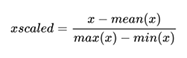

In [1013]:
from sklearn.preprocessing import StandardScaler, RobustScaler

In [1014]:
scaler_mean = StandardScaler(with_mean=True, with_std=False)
scaler_minmax = RobustScaler(with_centering=False, with_scaling=True, quantile_range=(0, 100))

In [1015]:
scaler_mean.fit(data_num)
scaler_minmax.fit(data_num)

scaled = scaler_minmax.transform(scaler_mean.transform(data_num))
scaled_df = pd.DataFrame(scaled, columns=scaler_minmax.get_feature_names_out())

c:\dev\Kaggle-Titanic-Spacechip-Competion\.venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


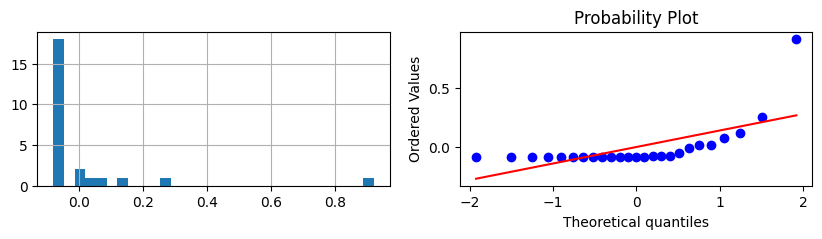

In [1016]:
diagnostic_plots(scaled_df, 'VRDeck')

### Min-max scaling <a id="min_max_scaler"></a>

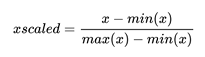

In [1017]:
# Imports
from sklearn.preprocessing import MinMaxScaler

In [1018]:
min_max_scaler = MinMaxScaler()
min_max_df = min_max_scaler.fit_transform(data_num)
min_max_df = pd.DataFrame(min_max_df, columns=min_max_scaler.get_feature_names_out())

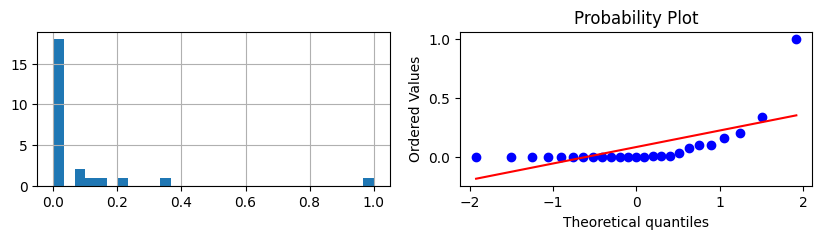

In [1019]:
diagnostic_plots(min_max_df, 'VRDeck')

### Absolute scaling <a id="absolute_scaler"></a>

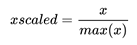

In [1020]:
# Imports
from sklearn.preprocessing import MaxAbsScaler

In [1021]:
absolute_scaler = MaxAbsScaler()
absolute_df = absolute_scaler.fit_transform(data_num)
absolute_df = pd.DataFrame(absolute_df, columns=absolute_scaler.get_feature_names_out())

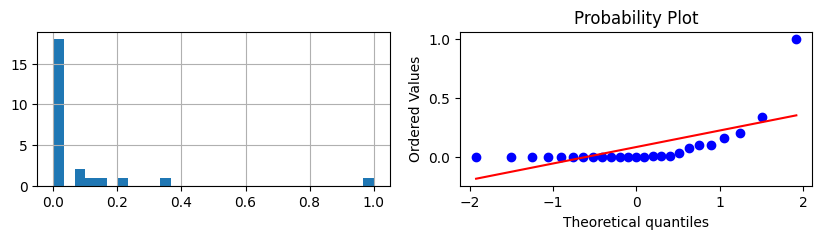

In [1022]:
diagnostic_plots(absolute_df, 'VRDeck')

## Mathematical computations <a id="math"></a>

### Statistical operations <a id="statistical"></a>

In [1023]:
df_t = data_num.agg(['sum','prod','mean','std', 'max', 'min'], axis='columns')
df_t

,sum,prod,mean,std,max,min
991,585.0,0.0,97.500000,153.747520,376.0,0.0
4508,18.0,0.0,3.000000,7.348469,18.0,0.0
4577,908.0,0.0,151.333333,213.741589,483.0,0.0
29,1238.0,0.0,206.333333,397.847542,998.0,0.0
194,1582.0,0.0,263.666667,614.221676,1517.0,0.0
3348,31.0,0.0,5.166667,12.655697,31.0,0.0
4232,3381.0,0.0,563.500000,947.988344,2376.0,0.0
2329,1197.0,0.0,199.500000,463.498328,1145.0,0.0
1627,1002.0,0.0,167.000000,339.711642,852.0,0.0
698,802.0,0.0,133.666667,317.176712,781.0,0.0


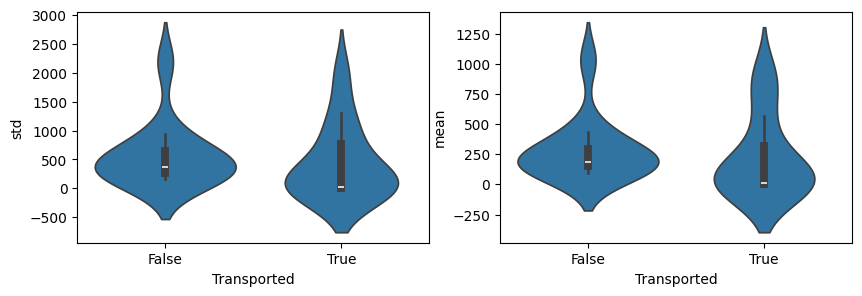

In [1024]:
y.index = df_t.index

df_t_concat = pd.concat([df_t, y],axis=1)

plt.figure(figsize=(10,3))
plt.subplot(1, 2, 1)
sns.violinplot(x="Transported", y="std", data=df_t_concat)
plt.subplot(1, 2, 2)
sns.violinplot(x="Transported", y="mean", data=df_t_concat)
plt.show()

### Polynomial expansion <a id="polynomial"></a>

In [1025]:
from sklearn.preprocessing import PolynomialFeatures

In [1026]:
poly = PolynomialFeatures(degree=3, interaction_only=False,include_bias=False)

poly_df = poly.fit_transform(data_num[['Spa', 'VRDeck', 'RoomService']])
poly_df = pd.DataFrame(poly_df, columns=poly.get_feature_names_out())

In [1027]:
poly_df

,Spa,VRDeck,RoomService,Spa^2,Spa VRDeck,Spa RoomService,VRDeck^2,VRDeck RoomService,RoomService^2,Spa^3,Spa^2 VRDeck,Spa^2 RoomService,Spa VRDeck^2,Spa VRDeck RoomService,Spa RoomService^2,VRDeck^3,VRDeck^2 RoomService,VRDeck RoomService^2,RoomService^3
0,0.0,376.0,182.0,0.0,0.0,0.0,141376.0,68432.0,33124.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,5.315738e+07,25730432.0,12454624.0,6.028568e+06
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00
2,12.0,483.0,362.0,144.0,5796.0,4344.0,233289.0,174846.0,131044.0,1.728000e+03,6.955200e+04,52128.0,2799468.0,2098152.0,1572528.0,1.126786e+08,84450618.0,63294252.0,4.743793e+07
3,998.0,0.0,0.0,996004.0,0.0,0.0,0.0,0.0,0.0,9.940120e+08,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00
4,27.0,0.0,1517.0,729.0,0.0,40959.0,0.0,0.0,2301289.0,1.968300e+04,0.000000e+00,1105893.0,0.0,0.0,62134803.0,0.000000e+00,0.0,0.0,3.491055e+09
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00
6,39.0,2376.0,0.0,1521.0,92664.0,0.0,5645376.0,0.0,0.0,5.931900e+04,3.613896e+06,0.0,220169664.0,0.0,0.0,1.341341e+10,0.0,0.0,0.000000e+00
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00
8,135.0,0.0,852.0,18225.0,0.0,115020.0,0.0,0.0,725904.0,2.460375e+06,0.000000e+00,15527700.0,0.0,0.0,97997040.0,0.000000e+00,0.0,0.0,6.184702e+08
9,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,49.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,3.430000e+02


In [1028]:
def plot_features(df, target):
    nb_rows = 5
    nb_cols = 4
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(12, 12))
    plt.subplots_adjust(wspace=None, hspace=0.4)
    n = 0
    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            if n!=19:
                axs[i, j].scatter(df[df.columns[n]], target)
                axs[i, j].set_title(df.columns[n])
                n += 1
    plt.show()

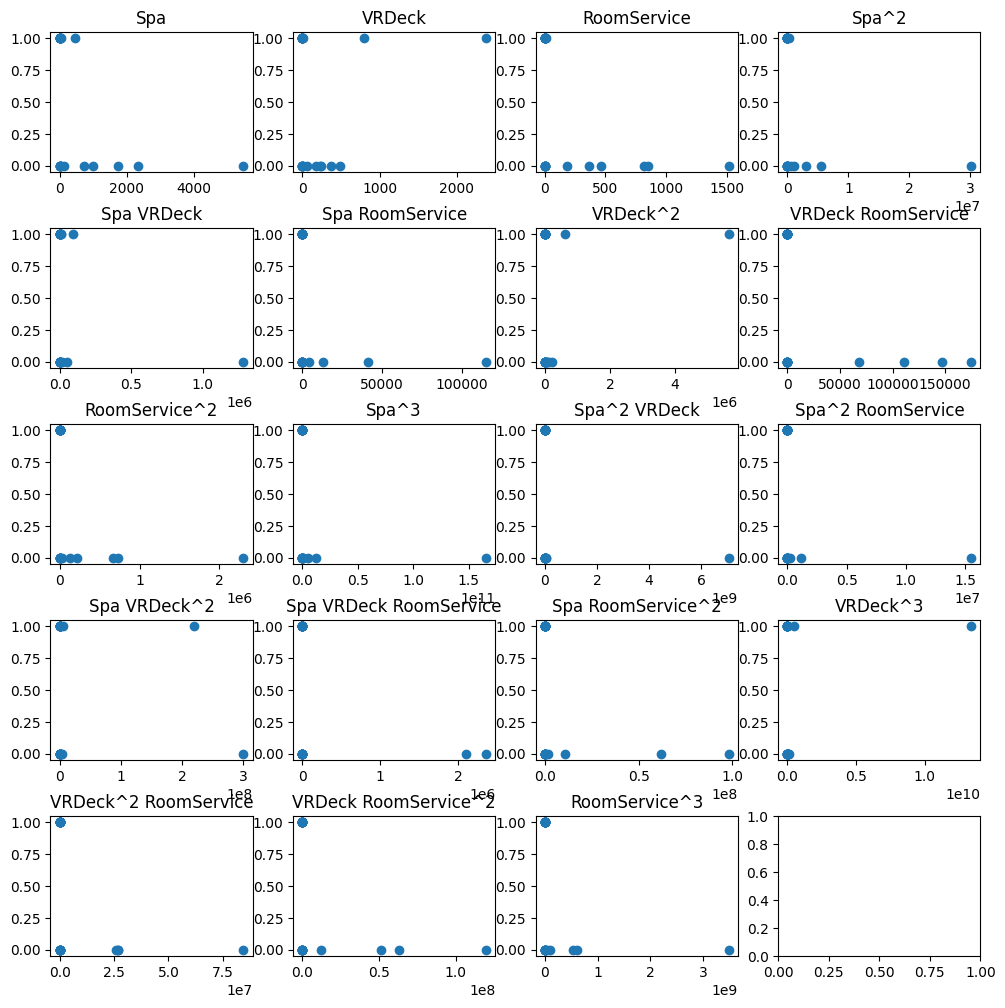

In [1029]:
plot_features(poly_df, y)

### Deriving new features with decision trees <a id="new_feat_tree"></a>

In [1030]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

In [1031]:
param_grid = {'max_depth': [3, 4, None]}

tree_model = GridSearchCV(DecisionTreeClassifier(random_state=0),
                          cv = 5,
                          scoring = 'accuracy',
                          param_grid = param_grid)

In [1032]:
tree_model.fit(data_num[['Spa', 'VRDeck', 'RoomService']], y)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_depth': [3, 4, None]}, scoring='accuracy')

In [1033]:
data_num['new_feat'] = tree_model.predict(data_num[['Spa', 'VRDeck', 'RoomService']])

In [1034]:
pd.concat([data_num, y], axis=1)

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,new_feat,Transported
991,27.0,182.0,0.0,0.0,0.0,376.0,False,False
4508,18.0,0.0,0.0,0.0,0.0,0.0,True,True
4577,20.0,362.0,0.0,31.0,12.0,483.0,False,False
29,15.0,0.0,225.0,0.0,998.0,0.0,False,False
194,38.0,1517.0,0.0,0.0,27.0,0.0,False,False
3348,31.0,0.0,0.0,0.0,0.0,0.0,True,True
4232,53.0,0.0,864.0,49.0,39.0,2376.0,True,True
2329,43.0,0.0,9.0,1145.0,0.0,0.0,True,False
1627,15.0,852.0,0.0,0.0,135.0,0.0,False,False
698,14.0,7.0,781.0,0.0,0.0,0.0,True,True


Text(0.5, 0, 'new_feat')

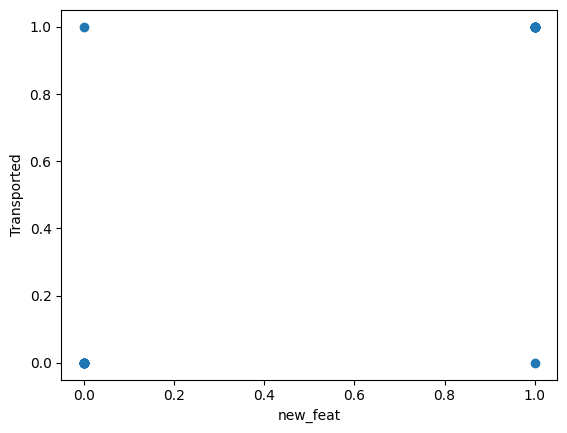

In [1035]:
plt.scatter(data_num['new_feat'], y)
plt.ylabel('Transported')
plt.xlabel('new_feat')

### Principal Component Analysis <a id="pca"></a>

In [1036]:
# Imports
from sklearn.decomposition import PCA

In [1037]:
pca = PCA(n_components=None)

pca_df = pca.fit_transform(data_num)
pca_df = pd.DataFrame(pca_df, columns=pca.get_feature_names_out())

Text(0, 0.5, 'Percentage of Variance Explained')

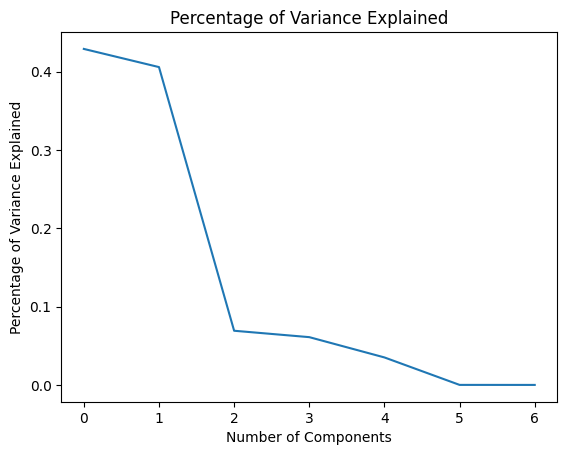

In [1038]:
plt.plot(pca.explained_variance_ratio_)
plt.title('Percentage of Variance Explained')
plt.xlabel('Number of Components')
plt.ylabel('Percentage of Variance Explained')

In [1039]:
pca_df

,pca0,pca1,pca2,pca3,pca4,pca5,pca6
0,-570.892924,-359.415385,232.487740,-130.449538,-87.405608,-1.397422,-0.616489
1,-555.674848,-386.386322,-133.097230,-90.413695,-283.223542,-6.111456,0.307995
2,-574.258218,-360.086800,329.060747,-156.530201,99.436372,-10.041430,-0.434727
3,463.349430,-396.058185,-132.968209,-63.853968,-197.442069,-14.511306,-0.414547
4,-635.870407,-476.526020,-191.296956,-610.964624,1135.652614,10.990660,0.347684
5,-555.612226,-386.408873,-132.963764,-90.359496,-283.169506,6.887168,0.220381
6,-339.332750,675.841315,2136.929480,45.938513,-59.273963,4.884045,0.103869
7,-613.602430,-323.711265,-231.077134,978.736093,105.817466,14.207276,-0.073348
8,-484.570817,-464.248916,-163.368401,-377.970257,522.622055,-11.431473,0.016971
9,-378.433818,367.713184,-206.916193,-141.164274,-239.484770,-8.869212,0.391402


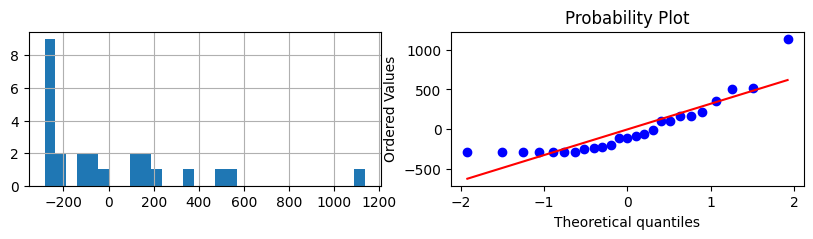

In [1040]:
diagnostic_plots(pca_df, 'pca4')